# ▶ Ejercicio 2.
Leer y graficar los datos pertenecientes a la funcion de luminosidad de galaxias obtenida por Blanton et al. (2001). La figura de interes se reproduce a continuacion. Los datos correspondientes a la funcion
de luminosidad se pueden descargar del aula virtual.

---

La **función de luminosidad** describe cuántas galaxias existen por unidad de volumen y por intervalo de magnitud absoluta $M$. Se suele ajustar con la **función de Schechter**:

$$
\Phi(M) = 0.4\,\ln(10)\,\Phi^*\,10^{-0.4(M - M^*)(\alpha + 1)} \exp[-10^{-0.4(M - M^*)}]
$$

donde:  
- $\Phi^*$ es la densidad característica (gal $Mpc^{-3}$ $mag^{-1}$)
- $M^*$ la magnitud de corte 
- $\alpha$ la pendiente de la cola de galaxias débiles.


En este ejercicio simplemente **se leen y grafican los datos** pertenecientes a la funcion de luminosidad obtenida por *Blanton et al.* (2001), **se grafica la función observada** en el plano $(M,\,\Phi)$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ================================
# 1) Lectura de los datos
# ================================

# Cargamos los datos desde un archivo CSV
datos = pd.read_csv("datos_Blanton.csv")

# Visualizamos las primeras filas para comprobar
datos.head()


,MAG,PHI,error_inf,error_sup
0,-23.183,0.000003,0.000001,0.000006
1,-23.020,0.000005,0.000003,0.000011
2,-22.870,0.000017,0.000013,0.000026
3,-22.698,0.000035,0.000025,0.000044
4,-22.565,0.000082,0.000058,0.000105


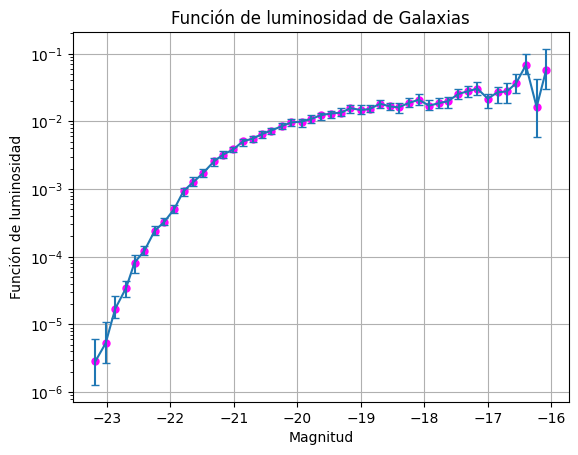

In [4]:
# ========================================
# 2) Gráfico de la función de luminosidad
# ========================================
M = datos["MAG"]
phi = datos["PHI"]
# Cálculo del error superior e inferior
err_inf = phi - datos["error_inf"]
err_sup = datos["error_sup"] - phi
phi_err = [err_inf, err_sup]

plt.plot(M, phi, 'o', ms=5, color='fuchsia')
plt.errorbar(M, phi, yerr=phi_err, capsize=3)  # para agregar las barras de error
plt.title('Función de luminosidad de Galaxias')
plt.xlabel('Magnitud')
plt.ylabel('Función de luminosidad')
plt.yscale('log')
plt.grid()
plt.show()  

# ▶ Ejercicio 3. 
Se desea ajustar el modelo m al conjunto de datos d, mediante un analisis Bayesiano. Para el caso de los datos del Ej. 2, se utilizara como modelo la funcion de Schechter: 
$$  Φ(M)dM =0.4 ln(10)Φ∗10−0.4(M−M∗)(α+1) ×exp(−10−0.4(M−M∗))dM $$

Los parametros que se intentan determinar son ϕ∗, M∗ y α. Para ello, escribir en python las siguientes
funciones:
- la funcion de likelihood
- la funcion de priors
- la funcion de probabilidad posterior

Estas funciones se necesitaran cuando se explore el espacio de parametros. Determine claramente los  parametros de entrada y de salida de estas funciones e implementelas en un programa. Explicite las  hipotesis que intervienen en este planteo (especialmente respecto de los errores), la motivacion de dichas hipotesis y las simplificaciones que se consiguen. Utilizando estas funciones, implementar un algoritmo de Metropolis-Hastings para explorar el espacio de parametros. Los parametros del algoritmo son el largo de la cadena (un numero entero) y las funciones prior. Tener en cuenta que los priors contienen el conocimiento previo sobre los datos. Los priors mas comunes son funciones planas y funciones gaussianas. Explicar que parametros intervienen, como y porque se eligen sus valores. Experimentar con distintas funciones de prior y evaluar su impacto en la realizacion de las cadenas.

---

## Primero

En el siguiente gráfico se muestran los **datos** de la función de luminosidad obtenida por *Blanton et al.* (2001) para galaxias del SDSS, junto con la **curva teórica de Schechter - modelo** con parámetros característicos:
$M^* = -20.83, \quad \Phi^* = 1.46\times10^{-2}, \quad \alpha = -1.20.$

La curva teórica reproduce adecuadamente la forma de la función observada:  
una pendiente pronunciada hacia magnitudes débiles y una caída exponencial para las galaxias más brillantes.

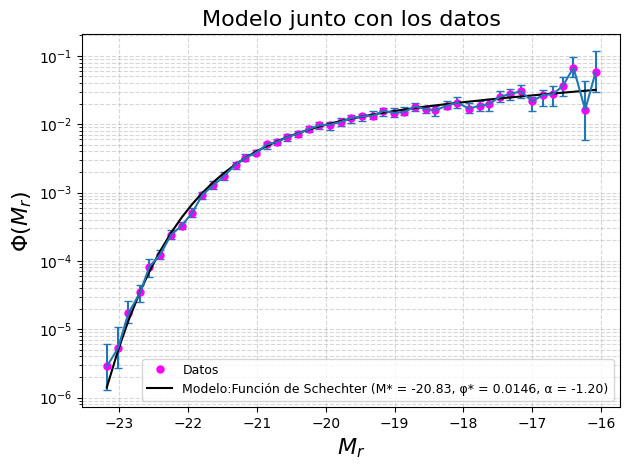

In [5]:
# ========================================
# Parámetros de la guía (Blanton et al. 2001)
# ========================================
p0 = [-20.83, 0.0146, -1.20]  # [M*, φ*, α]

# ========================================
# 1) Definición del modelo de Schechter
# ========================================
def phi_modelo(M, params=p0):
    """
    Modelo de función de luminosidad tipo Schechter.
    M: magnitudes absolutas
    params: [M*, φ*, α]
    """
    M0, phi0, alpha = params
    y = 0.4 * np.log(10) * phi0 * 10**(-0.4*(M - M0)*(alpha + 1)) * np.exp(-10**(-0.4*(M - M0)))
    return y

# ========================================
# 2) Gráfico de la función de luminosidad
# ========================================
M = datos["MAG"]
phi = datos["PHI"]

# Cálculo del error superior e inferior
err_inf = phi - datos["error_inf"]
err_sup = datos["error_sup"] - phi
phi_err = [err_inf, err_sup]


# Datos experimentales con barras de error
plt.errorbar(M, phi, yerr=phi_err, capsize=3)
plt.plot(M, phi, 'o', ms=5, color='fuchsia', label="Datos")


# Modelo teórico de Schechter
y_teor = phi_modelo(M)
plt.plot(M, y_teor, color="black", lw=1.5,
         label="Modelo:Función de Schechter (M* = -20.83, φ* = 0.0146, α = -1.20)")

# Grafico final
plt.xlabel("$M_r$", fontsize=16)
plt.ylabel("$\\Phi(M_r)$ ", fontsize=16)
plt.title("Modelo junto con los datos", fontsize=16)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.semilogy()
plt.legend(fontsize=9, loc="lower right")
plt.tight_layout()
plt.show()



Lo que se hace a continuación es ver de qué manera afecta cada parámetro al ajuste. Para ello, se realizan diferentes casos en los que se va variando uno u otro parámetro, observando en el gráfico a que región del modelo afecta dicho parámetro.

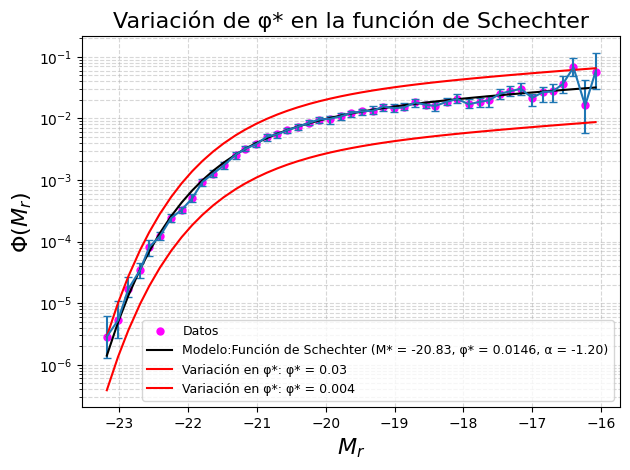

In [6]:
plt.plot(M, phi, 'o', ms=5, color='fuchsia', label="Datos")
plt.errorbar(M, phi, yerr=phi_err, capsize=3)

# Modelo teórico de Schechter
y_teor = phi_modelo(M)
plt.plot(M, y_teor, color="black", lw=1.5,
         label="Modelo:Función de Schechter (M* = -20.83, φ* = 0.0146, α = -1.20)")

# Modelo con variacion en phi*
y_teor_phi1 = phi_modelo(M, params=[-20.83, 0.03, -1.20])
y_teor_phi2 = phi_modelo(M, params=[-20.83, 0.004, -1.20])

plt.plot(M, y_teor_phi1, color="red", lw=1.5,
         label="Variación en φ*: φ* = 0.03")
plt.plot(M, y_teor_phi2, color="red", lw=1.5,
         label="Variación en φ*: φ* = 0.004")

# Grafico final
plt.xlabel("$M_r$", fontsize=16)
plt.ylabel("$\\Phi(M_r)$ ", fontsize=16)
plt.title("Variación de φ* en la función de Schechter", fontsize=16)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.semilogy()
plt.legend(fontsize=9, loc="lower right")
plt.tight_layout()
plt.show()



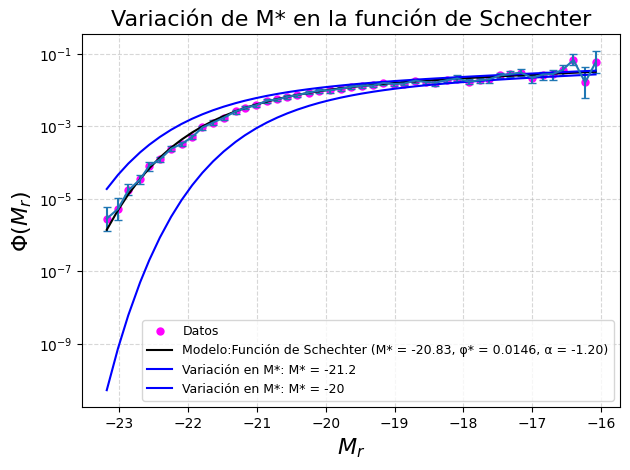

In [7]:
plt.plot(M, phi, 'o', ms=5, color='fuchsia', label="Datos")
plt.errorbar(M, phi, yerr=phi_err, capsize=3)

# Modelo teórico de Schechter
y_teor = phi_modelo(M)
plt.plot(M, y_teor, color="black", lw=1.5,
         label="Modelo:Función de Schechter (M* = -20.83, φ* = 0.0146, α = -1.20)")

# Modelo con variacion en M*
y_teor_M1 = phi_modelo(M, params=[-21.2, 0.0146, -1.20])
y_teor_M2 = phi_modelo(M, params=[-20, 0.0146, -1.20])

plt.plot(M, y_teor_M1, color="blue", lw=1.5,
         label="Variación en M*: M* = -21.2")
plt.plot(M, y_teor_M2, color="blue", lw=1.5,
         label="Variación en M*: M* = -20")

# Grafico final
plt.xlabel("$M_r$", fontsize=16)    
plt.ylabel("$\\Phi(M_r)$ ", fontsize=16)
plt.title("Variación de M* en la función de Schechter", fontsize=16)    
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.semilogy()
plt.legend(fontsize=9, loc="lower right")
plt.tight_layout()
plt.show()

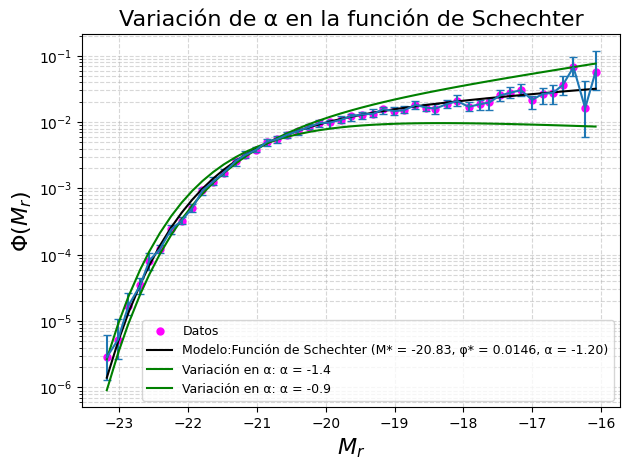

In [8]:
plt.plot(M, phi, 'o', ms=5, color='fuchsia', label="Datos")
plt.errorbar(M, phi, yerr=phi_err, capsize=3)

# Modelo teórico de Schechter
y_teor = phi_modelo(M)
plt.plot(M, y_teor, color="black", lw=1.5,
         label="Modelo:Función de Schechter (M* = -20.83, φ* = 0.0146, α = -1.20)")     

# Modelo con variacion en α
y_teor_a1 = phi_modelo(M, params=[-20.83, 0.0146, -1.4])
plt.plot(M, y_teor_a1, color="green", lw=1.5,
         label="Variación en α: α = -1.4")
y_teor_a2 = phi_modelo(M, params=[-20.83, 0.0146, -0.9])
plt.plot(M, y_teor_a2, color="green", lw=1.5,
         label="Variación en α: α = -0.9")

# Grafico final
plt.xlabel("$M_r$", fontsize=16)
plt.ylabel("$\\Phi(M_r)$ ", fontsize=16)
plt.title("Variación de α en la función de Schechter", fontsize=16)             
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.semilogy()
plt.legend(fontsize=9, loc="lower right")
plt.tight_layout()
plt.show()

Finalmente, se deduce que $\phi^*$ desplaza el modelo hacia arriba o hacia abajo, $M^*$ controla la subida de la función en el eje de las magnitudes y por último, $\alpha$ influye en la pendiente de la parte lineal.


### Segundo

Pero... **¿los parámetros presentados en el paper son realmente los mejores para ajustar los datos?** 

Para responder esta pregunta, lo que se hace a continuación es utilizar el likelihood, los prior y las funciones de probabilidad posterior para realizar las cadenas de Markov. De esta manera, se logra muestrear el espacio de parámetros y afirmar o no, si los parámetros del paper son realmente los mejores para el ajuste.

La inferencia estadistica se puede llevar a cabo como una aplicacion del teorema de Bayes. Dado un conjunto de datos d que se puede describir mediante un modelo m con parametros $\phi$, se desea obtener el mejor ajuste. 

EL objetivo es maximizar la probabilidad posterior de los parametros $p(\phi | d,m)$, para un modelo parametrico m, dados los datos (que el modelo intenta describir).

Por otro lado, se tiene que esta probabilidad posterior es proporcional al Likelihood $p(d | \phi,m) = \prod_{j=1}^N \exp(-(\frac{Phi[j] - m(Mag[j],\phi)}{\sigma[j]})^2) $, al prior $ p(\phi,m)$ es decir aquello que ya se conoce de los parametros, y  esta normalizado por la evidencia  $p(d,m) $ la cual se toma en este caso igual a 1, i.e $p(d,m)=1$. Por lo tanto:
$$ Probabilidad\,\, Posterior:\,\,  p(\phi | d,m) = \frac{p(d | \phi,m)p(\phi,m)}{p(d,m)=1} = p(d | \phi,m)p(\phi,m)           $$

Se puede observar del analisis anterior que variando cada uno de los parametros y manteniendo al resto fijos, se puede definir cierto intervalo para cada parametro, cuyos valores extremos estan dados por estas funciones limites que ya se desvian suficientemente de los datos como para decir que ya no producen un buen ajuste.

Se definen entonces los siguientes intervalos como los más probables de contener los valores óptimos de los parámetros:

$$ I_{M_0} = (-21.2 , -20) $$

$$ I_{\phi_0} = (0.004 , 0.03) $$

$$ I_{\alpha_0} = (-1.4 , -0.9) $$

Dado que, a priori, no se tiene más información que esta respecto de los valores que pueden llegar a tener los parámetros, se utilizará un *prior* plano (distribución uniforme), definido como:

$$
p(\phi,m) =
\begin{cases}
1, & \text{si } \phi \in R \\[6pt]
0, & \text{caso contrario.}
\end{cases}
$$

donde $R$ es una región en el espacio tridimensional dada por:

$$ R = I_{M_0} \times I_{\phi_0} \times I_{\alpha_0} $$

Entonces, esta función devuelve un valor constante si se encuentra dentro de la región que se va a muestrear, mientras que es nula fuera de esa región.  

Luego, se definen las funciones relevantes: *Likelihood*, *Prior* y *Probabilidad Posterior*.  
Al final se decidió trabajar con el logaritmo de dichas funciones, pues es más cómodo y no cambia el comportamiento (creciente o decreciente) de las mismas.

$$
\log(\text{Likelihood}) =
\log(p(d \mid \phi,m)) =
\sum_{j=1}^{N}
-\left(
\frac{\Phi_j - m(\text{Mag}_j,\phi)}{\sigma_j}
\right)^2
$$

$$
\log(\text{Prior}) =
\begin{cases}
0, & \text{si } \phi \in R \\[6pt]
-\infty, & \text{caso contrario.}
\end{cases}
$$

$$
\log(\text{Probabilidad Posterior}) =
\log(p(\phi \mid d,m)) =
\begin{cases}
\log(p(d \mid \phi,m)), & \text{si } \phi \in R \\[6pt]
-\infty, & \text{caso contrario.}
\end{cases}
$$


In [9]:
I_M = (-21.2 , -20)
I_phi = (0.004 , 0.03)
I_alpha = (-1.4 , -0.9)

p0 = [ -20.83, 0.0146, -1.20 ]

# Defino las funciones log(Likelihood), log(Prior) y log(Prob_Posterior)
# data será la tupla (M_obs, phi_obs, sigma_obs)

def log_likelihood(data, model, parametros):
    """
    data: (M_obs, phi_obs, sigma_obs) -- arrays del mismo largo
    model: model(M, parametros)
    parametros: lista [M*, phi*, alpha]
    Devuelve el log-likelihood para errores gaussianos independientes: -0.5 * sum(((phi - model)/sigma)**2)
    """
    M_obs, phi_obs, sigma_obs = data
    phi_model = model(M_obs, parametros)

    # Chi-cuadrado para errores gaussianos
    chi2 = np.sum(((phi_obs - phi_model) / sigma_obs)**2)
    
    # Log-likelihood (sin constantes de normalización)
    return -0.5 * chi2

# Preparamos los datos para la función de log-likelihood
sigma = (datos["error_sup"] - datos["error_inf"]) / 2  # Error promedio
data = (M, phi, sigma) 

In [10]:
p0 = [-20.83, 0.0146, -1.20]
print("Log-Likelihood con parametros dados por Blanton", p0, ":", log_likelihood(data, phi_modelo, p0))
p1 = [-21.2, 0.03, -1.4]
print("Log-Likelihood con parametros ", p1, ":", log_likelihood(data, phi_modelo, p1))

Log-Likelihood con parametros dados por Blanton [-20.83, 0.0146, -1.2] : -14.859291970919925
Log-Likelihood con parametros  [-21.2, 0.03, -1.4] : -10424.41647623143


A medida que los parámetros utilizados se acercan más a los valores predichos por el modelo, el likelihood(como es una funcion de probabilidad va entre 0 y 1) debe ir aumentando pues se está maximizando. Luego la funcion que definimos, esta funcionando bien.
Notar que estoy trabajando en logaritmos, luego los valores obtenidos son negativos pues log de valores entre 0 y 1 son negativos.

Para la funcion distribucion a priori (Prior)  de los parámetros, como ya se menciono antes se toma una distribución plana, asumiendo que no se conoce nada de los parámetros. Entonces, esta función devuelve un valor constante si se encuentra dentro de la región que se va a muestrear, mientras que es nula fuera de esa región. Pero quiero ver el log(Prior) entonces se define asi:

In [11]:
def log_prior(parametros):
    """
    Prior uniforme en las regiones definidas, -inf fuera de ellas
    parametros: lista [M*, phi*, alpha]
    """
    M_star, phi_star, alpha = parametros
    
    # Verificar si los parámetros están dentro de los intervalos permitidos
    if (I_M[0] <= M_star <= I_M[1] and 
        I_phi[0] <= phi_star <= I_phi[1] and 
        I_alpha[0] <= alpha <= I_alpha[1]):
        return 0.0  # log(1) = 0 para prior uniforme
    else:
        return -np.inf  # log(0) = -inf fuera de la región

Para la función de probabilidad posterior (Probabilidad Posterior) se utiliza el Teorema de Bayes, como mencionamos antes. Ademas la evidencia es 1, con lo cual la Prob. Posterior es el producto de Likelihood y Prior, pero en log(prob_posterior) esto es la suma.

In [12]:
def log_posterior(data, model, parametros):
    """
    Probabilidad posterior = likelihood * prior
    En logaritmos: log_posterior = log_likelihood + log_prior
    """
    log_prior_val = log_prior(parametros)
    
    # Si el prior es -inf, no hace falta calcular el likelihood
    if log_prior_val == -np.inf:
        return -np.inf
    
    log_like = log_likelihood(data, model, parametros)
    return log_like + log_prior_val

In [13]:
print("Log-Prob_Posterior con parametros dados por Blanton", p0, ":", log_posterior(data, phi_modelo, p0))
print("Log-Prob_Posterior con parametros ", p1, ":", log_posterior(data, phi_modelo, p1))

Log-Prob_Posterior con parametros dados por Blanton [-20.83, 0.0146, -1.2] : -14.859291970919925
Log-Prob_Posterior con parametros  [-21.2, 0.03, -1.4] : -10424.41647623143


Notar que el prior es nulo pues estoy trabajando con log, entonces maximizar likelihood es lo mismo que maximizar posterior.


Para reafirmar que la función Probabilidad Posterior está andando correctamente, sería útil probar con más puntos. Como en este caso se está maximizando, al utilizar la función posterior haciendo variar en i a cada uno de los parámetros, se deberían ver curvas que suban, lleguen a un máximo y luego bajen. A continuación se realizan los tres casos.

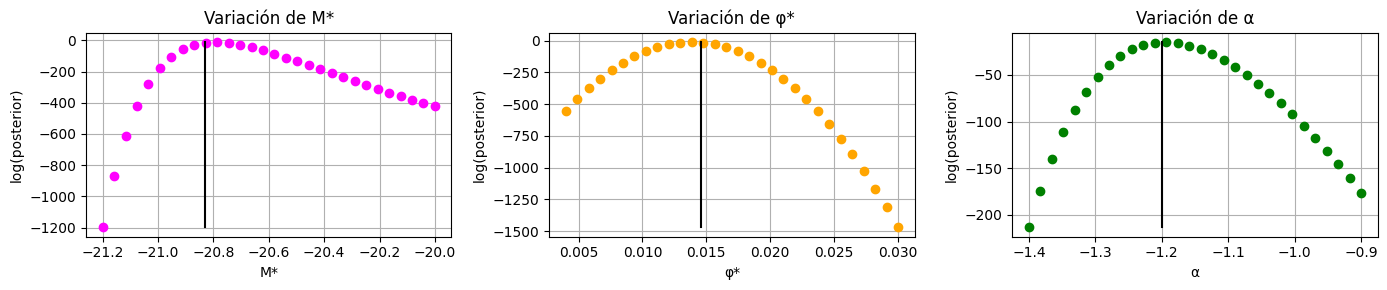

In [14]:
M0c = np.linspace(-21.2, -20, 30)
phi0c = np.linspace(0.004, 0.03, 30)
alpha0c = np.linspace(-1.4, -0.9, 30) 

a = []
b = []
c = []

plt.figure(figsize=(14, 3))


# Subplot 1: Variación de M*
plt.subplot(1, 3, 1)
for i in range(30):
    params = [M0c[i], 0.0146, -1.2]
    a.append(log_posterior(data, phi_modelo, params))
plt.plot(M0c, a, 'o', color="fuchsia")
plt.plot([-20.83, -20.83], [min(a), max(a)], color="black")
plt.xlabel('M*')
plt.ylabel('log(posterior)')
plt.title('Variación de M*')
plt.grid()

# Subplot 2: Variación de phi*
plt.subplot(1, 3, 2)
for i in range(30):
    params = [-20.83, phi0c[i], -1.2] 
    b.append(log_posterior(data, phi_modelo, params))
plt.plot(phi0c, b, 'o', color="orange")
plt.plot([0.0146, 0.0146], [min(b), max(b)], color="black")
plt.xlabel('φ*')
plt.ylabel('log(posterior)')
plt.title('Variación de φ*')
plt.grid()

# Subplot 3: Variación de α
plt.subplot(1, 3, 3)
for i in range(30):
    params = [-20.83, 0.0146, alpha0c[i]] 
    c.append(log_posterior(data, phi_modelo, params))
plt.plot(alpha0c, c, 'o', color="green")
plt.plot([-1.2, -1.2], [min(c), max(c)], color="black")
plt.xlabel('α')
plt.ylabel('log(posterior)')
plt.title('Variación de α')
plt.grid()

plt.tight_layout()
plt.show()


Como se observa en los gráficos, se obtiene el comportamiento esperando en el caso de maximización. Además, se agregaron las líneas negras que están marcando los correspondientes parámetros encontrados por Blanton para chequear que los máximos de las curvas estén próximos a esos valores.

Se obtienen las distribuciones posteriores para cada parametro. Explicado rapidamente: Una cadena MCMC me genera las distribuciones que mejor se aproximan a las distribuciones posteriores de cada parametro. El Metropolis-Hastings es un algoritmo de como obtener cadenas MCMC. 

Finalmente me quedo con el maximo de cada posterior, para obtener los parametros optimos del modelo.

## Tercero

Utilizando las funciones anteriores, quiero implementar un algoritmo de Metropolis-Hastings para explorar el espacio de parametros. Pero antes un pequeño repaso:


### ¿QUE QUIERO HACER?

Implementar un ajuste bayesiano de la función de Schechter a los datos de luminosidad de galaxias. El objetivo es encontrar los mejores valores de los parámetros (M*, φ*, α) que describan los datos, y también cuantificar la incertidumbre en esos parámetros. Es decir encontrar la **distribución completa** de parámetros posibles y sus incertidumbres.


La ecuación fundamental es:

$$P(\text{parámetros} | \text{datos}) \propto P(\text{datos} | \text{parámetros}) \times P(\text{parámetros})$$

Donde:
- **$P(\text{parámetros} | \text{datos})$** = **Posterior**: Lo que queremos encontrar (distribución de probabilidad de los parámetros dados los datos)
- **$P(\text{datos} | \text{parámetros})$** = **Likelihood**: Qué tan bien el modelo con ciertos parámetros explica los datos observados  
- **$P(\text{parámetros})$** = **Prior**: Lo que sabemos a priori sobre los parámetros

La región permitida es donde defino que los parámetros pueden tomar valores **físicamente razonables**:

$I_{M^*} = (-21.2, -20)$

$I_{\phi^*} = (0.004, 0.03)$

$I_{\alpha} = (-1.4, -0.9)$


#### ¿Qué hace el algoritmo de Metropolis-Hastings?

El algoritmo **explora el espacio de parámetros** de manera inteligente:

1. **Propone un nuevo conjunto de parámetros** (ligeramente diferentes a los actuales)
2. **Evalúa qué tan bien explican los datos** (usando la probabilidad posterior)
3. **Acepta o rechaza** la propuesta basándose en si mejora o empeora el ajuste
4. **Repite miles de veces** para mapear toda la región de parámetros probables

#### Criterio de Aceptación de Metropolis

Para una propuesta de parámetros $\theta'$ dado el estado actual $\theta$:

$$\alpha = \min\left(1, \frac{P(\theta' | \text{datos})}{P(\theta | \text{datos})}\right)$$

- Si $\alpha = 1$ (la propuesta es mejor): **siempre aceptamos**
- Si $\alpha < 1$ (la propuesta es peor): **aceptamos con probabilidad** $\alpha$

Este mecanismo permite:
- **Explorar eficientemente** las regiones de alta probabilidad
- **Escapar ocasionalmente** de máximos locales
- **Generar muestras** que siguen la distribución posterior


#### Resultado Final

Al final obtendre:
- **Valores más probables** de M*, φ*, α (que pueden diferir de Blanton)
- **Incertidumbres** en cada parámetro
- **Correlaciones** entre parámetros  
- **Distribuciones marginales** de cada parámetro

**Esto es más informativo que el resultado de Blanton** porque nos da no solo "el mejor ajuste" sino toda la información sobre la incertidumbre y correlaciones entre parámetros.

### En Resumen
Estoy haciendo un análisis más completo que Blanton, que caracteriza completamente la incertidumbre en los parámetros del modelo de Schechter mediante el muestreo de la distribución posterior completa.

In [15]:
def metropolis_hastings(datos, modelo, funcion_log_posterior, parametros_iniciales, numero_pasos, tamaños_paso):
    """
    Algoritmo de Metropolis-Hastings para muestrear el espacio de parámetros
    
    Parámetros:
    - datos: tupla (M_obs, phi_obs, sigma_obs) con los datos observacionales
    - modelo: función del modelo (phi_modelo)
    - funcion_log_posterior: función que calcula log(posterior)
    - parametros_iniciales: parámetros iniciales [M*, phi*, alpha]
    - numero_pasos: número de pasos de la cadena
    - tamaños_paso: tamaños de paso para cada parámetro [paso_M, paso_phi, paso_alpha]
    
    Retorna:
    - cadena: array con la cadena de parámetros
    - aceptados: número de pasos aceptados
    """
    
    # Inicializar la cadena
    cadena = np.zeros((numero_pasos, len(parametros_iniciales)))
    parametros_actuales = np.array(parametros_iniciales)
    log_posterior_actual = funcion_log_posterior(datos, modelo, parametros_actuales)
    
    aceptados = 0
    
    for i in range(numero_pasos):
        # Proponer nuevos parámetros añadiendo ruido gaussiano
        propuesta = parametros_actuales + np.random.normal(0, tamaños_paso, len(parametros_actuales))
        
        # Calcular log(posterior) para los parámetros propuestos
        log_posterior_propuesta = funcion_log_posterior(datos, modelo, propuesta)
        
        # Calcular la razón de aceptación (en log)
        razon_logaritmica = log_posterior_propuesta - log_posterior_actual
        
        # Criterio de aceptación de Metropolis
        if razon_logaritmica > 0 or np.random.random() < np.exp(razon_logaritmica):
            # Aceptar la propuesta
            parametros_actuales = propuesta
            log_posterior_actual = log_posterior_propuesta
            aceptados += 1
        
        # Guardar el estado actual en la cadena
        cadena[i] = parametros_actuales
    
    return cadena, aceptados

# Parámetros para el algoritmo
numero_pasos = 10000  # Número de pasos de la cadena
tamaños_paso = [0.1, 0.002, 0.05]  # Tamaños de paso para [M*, phi*, alpha]
parametros_iniciales = [-20.83, 0.0146, -1.20]  # Parámetros iniciales (Blanton)

# Ejecutar Metropolis-Hastings
print("Ejecutando Metropolis-Hastings...")
cadena, numero_aceptados = metropolis_hastings(data, phi_modelo, log_posterior, 
                                             parametros_iniciales, numero_pasos, tamaños_paso)

# Calcular tasa de aceptación
tasa_aceptacion = numero_aceptados / numero_pasos


# Mostrar estadísticas de la cadena
print("\nEstadísticas de los parámetros muestreados:")
print(f"M* : media = {np.mean(cadena[:, 0]):.3f}, desv_std = {np.std(cadena[:, 0]):.3f}")
print(f"φ* : media = {np.mean(cadena[:, 1]):.5f}, desv_std = {np.std(cadena[:, 1]):.5f}")
print(f"α  : media = {np.mean(cadena[:, 2]):.3f}, desv_std = {np.std(cadena[:, 2]):.3f}")

Ejecutando Metropolis-Hastings...

Estadísticas de los parámetros muestreados:
M* : media = -20.772, desv_std = 0.037
φ* : media = 0.01509, desv_std = 0.00095
α  : media = -1.175, desv_std = 0.027


Por lo tanto, a partir del algoritmo de Metropolis Hastings se han obtenido los valores optimos de los parametros. Estos valores son aquellos con los que el modelo de Schechter mejor describe los datos:

$$ M_0 = -20.77 \pm 0.04  $$

$$ \phi_0 = (1.5 \pm 0.1) *10^{-2} $$

$$ \alpha_0 = -1.17 \pm 0.03  $$

In [16]:

_m = cadena[:,0]  # de la matriz me quedo con la primer columna que son los M
_phi = cadena[:,1]  # de la matriz me quedo con la segunda columna que son los  φ

_alpha = cadena[:,2]  # de la matriz me quedo con la tercer columna que son los α


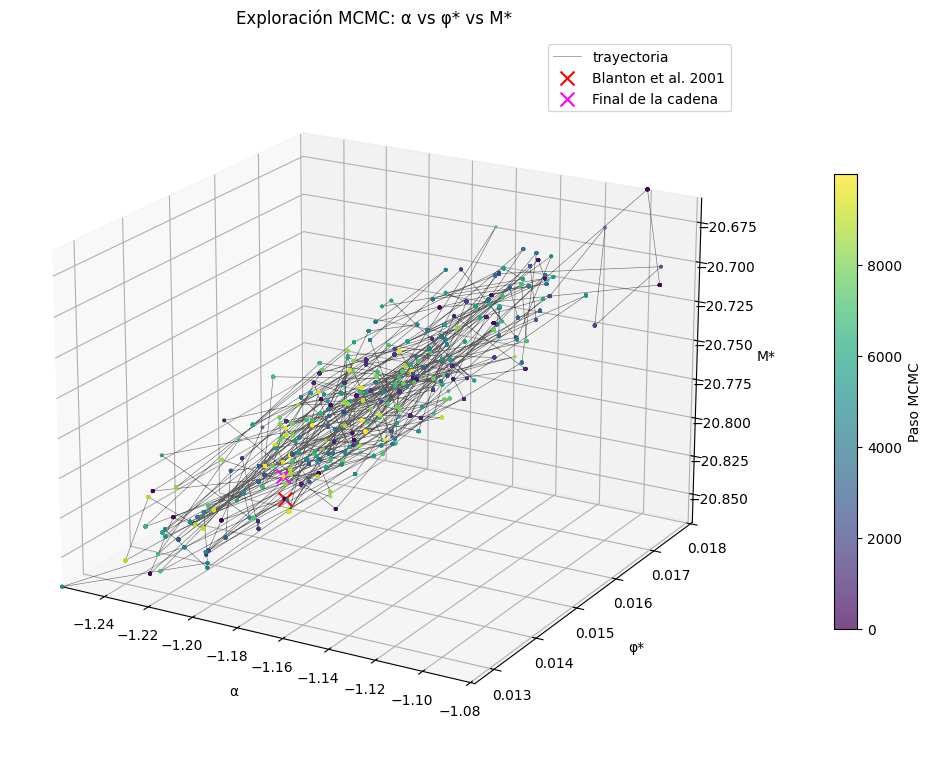

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Muestreo para no dibujar demasiados puntos (ajusta max_puntos)
max_puntos = 8000
n = len(cadena)
indices = np.arange(n)
muestra = np.random.choice(indices, size=min(max_puntos, n), replace=False)

# Colorear por orden de paso para ver la trayectoria temporal
colors = indices[muestra]

# Scatter de puntos muestreados
sc = ax.scatter(_alpha[muestra], _phi[muestra], _m[muestra],
                c=colors, cmap='viridis', s=8, alpha=0.7, edgecolors='none')

# Dibujar la trayectoria (línea fina) para una muestra ordenada
orden = np.argsort(indices[muestra])
ax.plot(_alpha[muestra][orden], _phi[muestra][orden], _m[muestra][orden],
        color='black', lw=0.4, alpha=0.6, label='trayectoria')

# Punto Blanton
ax.scatter(-1.20, 0.0146, -20.83, color='red', s=100, marker='x', label='Blanton et al. 2001')

# Punto final de la cadena
ax.scatter(_alpha[muestra][orden][-1], _phi[muestra][orden][-1], _m[muestra][orden][-1],
           color='fuchsia', s=100, marker='x', label='Final de la cadena')

#Leyenda
ax.legend()

# Etiquetas y título
ax.set_xlabel('α', labelpad=10)
ax.set_ylabel('φ*', labelpad=10)
ax.set_zlabel('M*', labelpad=10)
ax.set_title('Exploración MCMC: α vs φ* vs M*', pad=10)

# Ajustes de vista y límites 
ax.view_init(elev=20, azim=-60)
ax.set_xlim(np.min(_alpha), np.max(_alpha))
ax.set_ylim(np.min(_phi), np.max(_phi))
ax.set_zlim(np.min(_m), np.max(_m))

# Barra de color que indica el paso MCMC
cbar = fig.colorbar(sc, ax=ax, pad=0.1, shrink=0.6)
cbar.set_label('Paso MCMC')

ax.grid(True)
plt.tight_layout()
plt.show()

En el grafico anterior se visualiza la trayectoria en el espacio de parametros. Se observa que la cadena converge hacia un valor proximo al dado por Blanton.

# ▶ Ejercicio 4.

Visualizar las propiedades de convergencia de las cadenas. Encontrar condiciones de la simulacion para las cuales se produce un mal y un buen mezclado (mixing) de las cadenas. Para ello realize varias cadenas y comparelas.

---

## Visualización de la convergencia

La idea de este ejercicio es **diagnosticar** si la cadena MCMC que generamos en el Ej. 3 realmente
está explorando bien el espacio de parámetros $(M^*, \phi^*, \alpha)$.

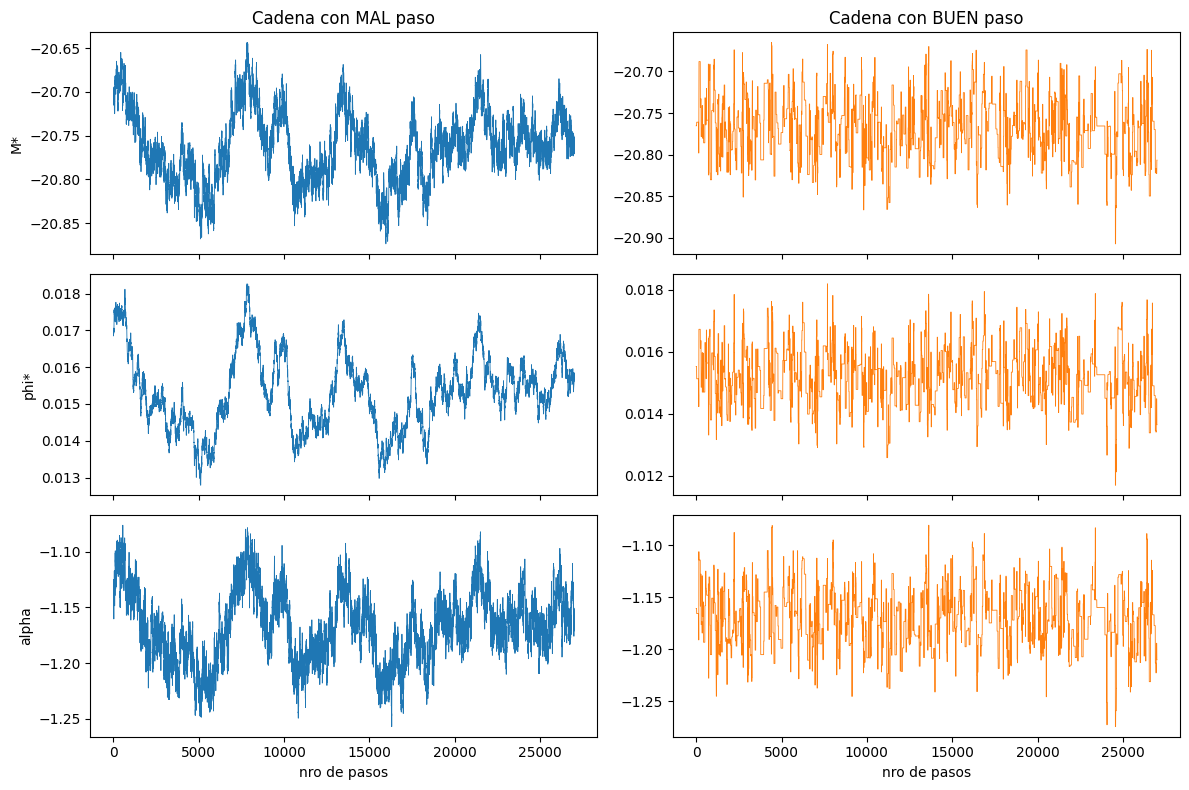

In [ ]:
# ------------------------------------------------------------------
# 1) Función auxiliar: correr UNA cadena con nuestra MH de antes
# ------------------------------------------------------------------
def correr_cadena(seed, x0, pasos, pasos_sigma):
    """
    Corre una cadena MCMC usando la función metropolis_hastings que ya definimos en el Ej. 3.
    Devuelve: cadena (array [pasos, 3]) y tasa de aceptación.
    """
    np.random.seed(seed)
    cadena, aceptados = metropolis_hastings(
        datos=data,
        modelo=phi_modelo,
        funcion_log_posterior=log_posterior,
        parametros_iniciales=x0,
        numero_pasos=pasos,
        tamaños_paso=pasos_sigma
    )
    tasa = aceptados / pasos
    return cadena, tasa

# ------------------------------------------------------------------
# 2) Probamos dos configuraciones de pasos:
#    - "mala": pasos muy chicos -> avanza lento
#    - "buena"
# ------------------------------------------------------------------
pasos_total = 30000

x0 = [-20.8, 0.015, -1.1]   # algo razonable dentro de los priors

# pasos muy chicos -> mal mezclado
pasos_malos = [0.005, 0.00005, 0.005]

# pasos razonables
pasos_buenos = [0.10, 0.002, 0.05]

cadena_mala, tasa_mala = correr_cadena(seed=1, x0=x0, pasos=pasos_total, pasos_sigma=pasos_malos)
cadena_buena, tasa_buena = correr_cadena(seed=2, x0=x0, pasos=pasos_total, pasos_sigma=pasos_buenos)


# ------------------------------------------------------------------
# 3) Tiramos las primeras muestras (burn-in)
# ------------------------------------------------------------------
burnin = 3000
cad_mala = cadena_mala[burnin:]
cad_buena = cadena_buena[burnin:]

steps_mala = np.arange(len(cad_mala))
steps_buena = np.arange(len(cad_buena))

# Separamos parámetros para que sea más cómodo
M_mala, phi_mala, alpha_mala   = cad_mala[:,0], cad_mala[:,1], cad_mala[:,2]
M_buena, phi_buena, alpha_buena = cad_buena[:,0], cad_buena[:,1], cad_buena[:,2]

# ------------------------------------------------------------------
# 4)  parámetro vs nro de pasos
# ------------------------------------------------------------------
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex='col')

axs[0,0].plot(steps_mala, M_mala, lw=0.6)
axs[0,0].set_ylabel("M*")
axs[0,0].set_title("Cadena con MAL paso")

axs[1,0].plot(steps_mala, phi_mala, lw=0.6)
axs[1,0].set_ylabel("phi*")

axs[2,0].plot(steps_mala, alpha_mala, lw=0.6)
axs[2,0].set_ylabel("alpha")
axs[2,0].set_xlabel("nro de pasos")

axs[0,1].plot(steps_buena, M_buena, lw=0.6, color='tab:orange')
axs[0,1].set_title("Cadena con BUEN paso")

axs[1,1].plot(steps_buena, phi_buena, lw=0.6, color='tab:orange')
axs[2,1].plot(steps_buena, alpha_buena, lw=0.6, color='tab:orange')
axs[2,1].set_xlabel("nro de pasos")

plt.tight_layout()
plt.show()




En este ejercicio se analizó la **convergencia** y el **mezclado (mixing)** de las cadenas generadas por el algoritmo de Metropolis–Hastings aplicado al ajuste de la función de Schechter.

En los *trace plots* de la Figura correspondiente se observa que, para una elección de tamaño de paso demasiado pequeño, la cadena presenta fuertes correlaciones entre pasos consecutivos y una exploración lenta del espacio de parámetros, lo que se traduce en un **mal mixing**.  
En cambio, al utilizar un tamaño de paso adecuado, los parámetros fluctúan de manera más aleatoria y cubren toda la región de alta probabilidad posterior, indicando una **buena mezcla y estabilidad** de la cadena.


# ▶ Ejercicio 5. 
Para una eleccion de parametros que produzca un buen mezclado, correr varias cadenas y compararlas.

---

## Comparación de varias cadenas

Objetivo: mostrar que, si el MCMC está bien tuneado, **cadenas independientes** (distintas semillas y
distintos puntos iniciales) terminan muestreando **la misma posterior**.

Pasos:
1. Elegimos los tamaños de paso "buenos" del Ej. 4.
2. Generamos varias condiciones iniciales dentro del prior.
3. Corremos, por ejemplo, 4 cadenas.

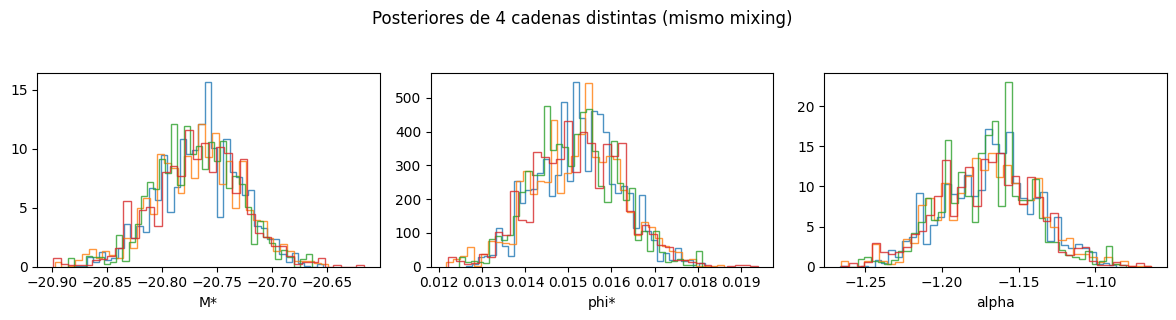

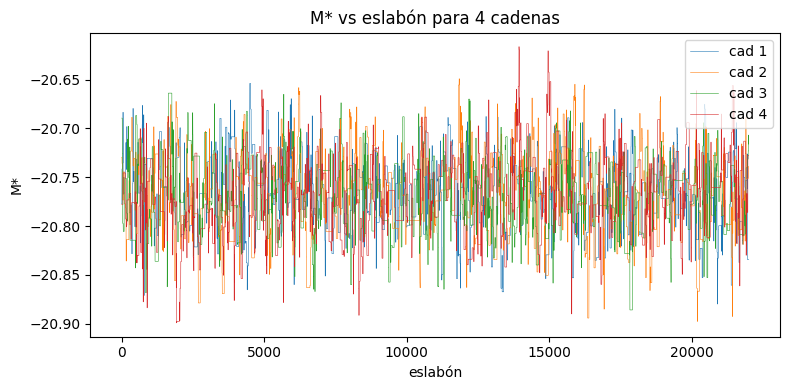

In [19]:
# ------------------------------
# 1) Configuración
# ------------------------------
pasos_total = 25000
burnin = 3000
pasos_buenos = [0.10, 0.002, 0.05]   # los mismos que antes

# Priors 
I_M     = (-21.2 , -20)
I_phi   = (0.004 , 0.03)
I_alpha = (-1.4 , -0.9)

def muestra_del_prior():
    M0 = np.random.uniform(*I_M)
    phi0 = np.random.uniform(*I_phi)
    a0 = np.random.uniform(*I_alpha)
    return [M0, phi0, a0]

def correr_cadena_buena(seed):
    np.random.seed(seed)
    x0 = muestra_del_prior()
    cad, acc = metropolis_hastings(
        datos=data,
        modelo=phi_modelo,
        funcion_log_posterior=log_posterior,
        parametros_iniciales=x0,
        numero_pasos=pasos_total,
        tamaños_paso=pasos_buenos
    )
    return cad, acc/pasos_total

# ------------------------------
# 2) Corremos varias cadenas
# ------------------------------
n_cadenas = 4
todas = []
tasas = []

for s in range(n_cadenas):
    cad, tasa = correr_cadena_buena(seed=10+s)
    todas.append(cad[burnin:])   # guardo sin burn-in
    tasas.append(tasa)


# Convertimos a array para trabajar más cómodo: shape -> (n_cadenas, n_pass, 3)
todas = np.array(todas)
n_pass = todas.shape[1]



# ------------------------------
# Histogramas superpuestos
# ------------------------------
fig, axs = plt.subplots(1, 3, figsize=(12,3))

colors = ['C0','C1','C2','C3']

for i in range(n_cadenas):
    axs[0].hist(todas[i,:,0], bins=40, histtype='step', color=colors[i], alpha=0.8, density=True)
    axs[1].hist(todas[i,:,1], bins=40, histtype='step', color=colors[i], alpha=0.8, density=True)
    axs[2].hist(todas[i,:,2], bins=40, histtype='step', color=colors[i], alpha=0.8, density=True)

axs[0].set_xlabel("M*")
axs[1].set_xlabel("phi*")
axs[2].set_xlabel("alpha")
fig.suptitle("Posteriores de 4 cadenas distintas (mismo mixing)", y=1.05)
plt.tight_layout()
plt.show()

# ------------------------------
#  Trace plot de todas juntas 
# ------------------------------
plt.figure(figsize=(8,4))
for i in range(n_cadenas):
    plt.plot(todas[i,:,0], lw=0.4, label=f"cad {i+1}")
plt.xlabel("eslabón")
plt.ylabel("M*")
plt.title("M* vs eslabón para 4 cadenas")
plt.legend()
plt.tight_layout()
plt.show()


En este ejercicio se corrieron varias cadenas independientes del algoritmo de Metropolis–Hastings, utilizando los mismos tamaños de paso que en el Ejercicio 4 (configuración con buen mixing), pero partiendo de **condiciones iniciales diferentes** muestreadas del prior.

El objetivo fue evaluar si todas las cadenas convergen hacia la misma región del espacio de parámetros, lo que indicaría que el muestreo de la distribución posterior es consistente y estable.

En el gráfico de $M^*$ versus el número de eslabón se observa que las cuatro cadenas, a pesar de partir de posiciones iniciales distintas, **convergen rápidamente hacia la misma región de valores** y presentan oscilaciones similares alrededor de la media posterior.  
Esto evidencia que el algoritmo olvidó las condiciones iniciales y que las cadenas están explorando la misma zona de alta probabilidad.

Los **histogramas de las distribuciones posteriores** para $M^*$, $\phi^*$ y $\alpha$ muestran una **superposición casi completa entre las cadenas**, confirmando que todas muestrean la misma distribución posterior y que el proceso MCMC se encuentra bien calibrado.

# ▶ Ejercicio 6
Implemente el metodo de gradiente descendente para encontrar el mınimo de Likelihood marginalizado a cada uno de los parametros. Discuta posibles cuestiones de precision, conveniencias e inconveniencias del metodo.

---

## Gradiente descendente y minimización de la función de Likelihood

El **gradiente descendente** es un método iterativo de optimización utilizado para encontrar el mínimo
de una función, en este caso, la **función de verosimilitud (Likelihood)** o su versión negativa
–el *Negative Log-Likelihood (NLL)*–.

La idea central es moverse en el espacio de parámetros en la dirección opuesta al gradiente de la función,
ya que el gradiente indica hacia dónde crece más rápidamente.  
Si se da un paso proporcional y en sentido contrario, se desciende hacia un mínimo local.



### Formulación general

Sea una función de costo $f(\boldsymbol{\theta})$ que depende de un conjunto de parámetros
$\boldsymbol{\theta} = (\theta_1, \theta_2, \ldots, \theta_n)$.
El método actualiza los parámetros según:

$$
\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_t - \eta \, \nabla f(\boldsymbol{\theta}_t)
$$

donde:
- $\eta$ es la **tasa de aprendizaje (learning rate)**, un número positivo pequeño que controla
  el tamaño del paso;
- $\nabla f(\boldsymbol{\theta}_t)$ es el **gradiente** de la función evaluado en la iteración $t$.

El proceso se repite hasta que se cumple algún criterio de convergencia, por ejemplo:
$$
|\boldsymbol{\theta}_{t+1} - \boldsymbol{\theta}_t| < \varepsilon
$$
o hasta que el valor de la función cambia menos que un umbral dado.



### Aplicación al caso astronómico

En este práctico se aplica el gradiente descendente para minimizar la **Likelihood marginalizada**
de la función de Schechter:

$$
\Phi(M) = 0.4 \ln(10)\,\Phi^*\,10^{-0.4(M - M^*)(\alpha + 1)} \,
\exp\!\big[-10^{-0.4(M - M^*)}\big]
$$

donde los parámetros a estimar son $ M^* $, $ \Phi^* $ y $ \alpha $.

La función a minimizar es el **negativo de la log-verosimilitud**:

$$
f(M^*, \Phi^*, \alpha) = -\,\ln \mathcal{L}(M^*, \Phi^*, \alpha)
$$

El gradiente descendente busca los valores de $ M^* $, $ \Phi^* $ y $ \alpha $ que minimizan esta función,
equivalentes a los parámetros que **maximizan la verosimilitud**.


### Interpretación y consideraciones numéricas

- Un valor de $\eta$ demasiado grande puede causar **inestabilidad** (saltos sobre el mínimo).
- Un $\eta$ demasiado pequeño produce **convergencia muy lenta**.
- El método encuentra el **mínimo local** más cercano al punto inicial, por lo que es importante
  una elección razonable de condiciones iniciales.
- En este contexto, el gradiente descendente es una alternativa determinista a MCMC:
  mientras MCMC explora toda la distribución posterior, el gradiente descendente sólo busca el punto
  de máxima probabilidad (el modo de la distribución).


En resumen, el gradiente descendente permite estimar de forma iterativa los parámetros más probables
de un modelo astronómico ajustado a datos observacionales, siendo una herramienta útil para complementar
los resultados obtenidos mediante inferencia bayesiana y métodos Monte Carlo.

## Finalmente:

En este ejercicio se aplica el método de **gradiente descendente** para encontrar el **mínimo de la función negativa de log-verosimilitud (NLL)** del modelo de Schechter.  
El objetivo es determinar los valores óptimos de los parámetros $(M^*, \phi^*, \alpha)$ que maximizan la probabilidad de reproducir los datos observados.

Se asume el mismo **prior plano** del Ejercicio 3, dentro de los intervalos:

$$
I_{M^*} = (-21.2,\,-20), \qquad
I_{\phi^*} = (0.004,\,0.03), \qquad
I_{\alpha} = (-1.4,\,-0.9)
$$

El gradiente descendente actualiza los parámetros en cada paso según

$$
\theta_{t+1} = \theta_t - \eta \, \nabla f(\theta_t),
$$

donde $f(\theta) = -\ln \mathcal{L}(\theta)$ y $\eta$ es la tasa de aprendizaje.  
Para simplificar, el gradiente se calcula numéricamente usando diferencias finitas y se detiene cuando el cambio en los parámetros es pequeño.

In [23]:
# defino el gradiente del (-)likelihood
M = datos['MAG']  # Cambio df por datos
phi = datos['PHI']  # Cambio tabla por datos y f por phi

def grad_likeli(par, x=M, y=phi, model=phi_modelo):   # Cambio phi_model por phi_modelo
    # Calcular sigma usando los errores
    err_inf = y - datos["error_inf"]
    err_sup = datos["error_sup"] - y
    sigma = (err_inf + err_sup) * 0.5

    m1 = model(x, par)   # par[0] = M0 , par[1] = Phi0 , par[2] = Alpha0
    g = -0.4*(x - par[0])
    factor = (-1 / sigma**2) * (y - m1)
    
    z = np.zeros(3)
    z[0] = np.sum(factor * m1 * np.log(10) * 0.4 * (par[2] + 1 - 10**g))
    z[1] = np.sum(factor * m1 / par[1])
    z[2] = np.sum(factor * m1 * np.log(10) * g)
    
    return z

# Prueba con los parámetros de Blanton
v = [-20.83, 0.0146, -1.2]
print("Gradiente en parámetros de Blanton:", grad_likeli(v))

Gradiente en parámetros de Blanton: [-222.4655469  8265.61632099  -26.44327721]


In [24]:
I_M = (-21.2 , -20)
I_phi = (0.004 , 0.03)
I_alpha = (-1.4 , -0.9)

M_sigma = ( I_M[1] -  I_M[0] )/50
phi_sigma = ( I_phi[1] -  I_phi[0] )/50.0
alpha_sigma = ( I_alpha[1] -  I_alpha[0] )/50.0

print(M_sigma, phi_sigma , alpha_sigma) 

0.023999999999999987 0.00052 0.009999999999999998


In [48]:

# Quiero minimizar el (-)Likelihood, luego redefino la funcion log_posterior como sigue:
def log_post(data, phi_modelo, v):
    return -log_likelihood(data, phi_modelo, v) - log_prior(v)

In [37]:
def Gradiente_Descendente(N, M0=-20.5, phi0=0.008, alpha0=-0.9):
    """
    Implementa gradiente descendente para optimizar parámetros de Schechter
    N: número de iteraciones
    M0, phi0, alpha0: parámetros iniciales
    """
    
    # Matriz para almacenar parámetros en cada iteración
    params = np.zeros((N, 3))
    params[0][0], params[0][1], params[0][2] = M0, phi0, alpha0
    
    # Array para almacenar valores de log-posterior en cada iteración
    Ls = np.zeros(N)
    
    for i in range(0, N-1):
        step = grad_likeli(params[i])
        norm = (step[0]**2 + step[1]**2 + step[2]**2)**(0.5)
        
        # Actualizar parámetros usando los tamaños de paso definidos
        params[i+1][0] = params[i][0] - (M_sigma * step[0]) / norm
        params[i+1][1] = params[i][1] - (phi_sigma * step[1]) / norm  # Cambio fi_sigma por phi_sigma
        params[i+1][2] = params[i][2] - (alpha_sigma * step[2]) / norm  # Cambio a_sigma por alpha_sigma
        
        # Calcular log-posterior para esta iteración
        Ls[i] = log_post(data, phi_modelo, params[i])  # Cambios: log_post -> log_posterior, [M,f] -> data, phi_model -> phi_modelo
        
    return params, Ls


In [38]:
N_final = 1500

parameters , L_grad = Gradiente_Descendente(N_final)
#print(L_grad)

print('Estos son los parametros finales, M_0 , phi_0, alpha_0', parameters[N_final-1,0], parameters[N_final-1,1], parameters[N_final-1,2])

Estos son los parametros finales, M_0 , phi_0, alpha_0 -20.770910453930146 0.015612543748403807 -1.1728479232737155


Text(0.5, 1.0, 'Corte en el Espacio de Parámetros, M = cte')

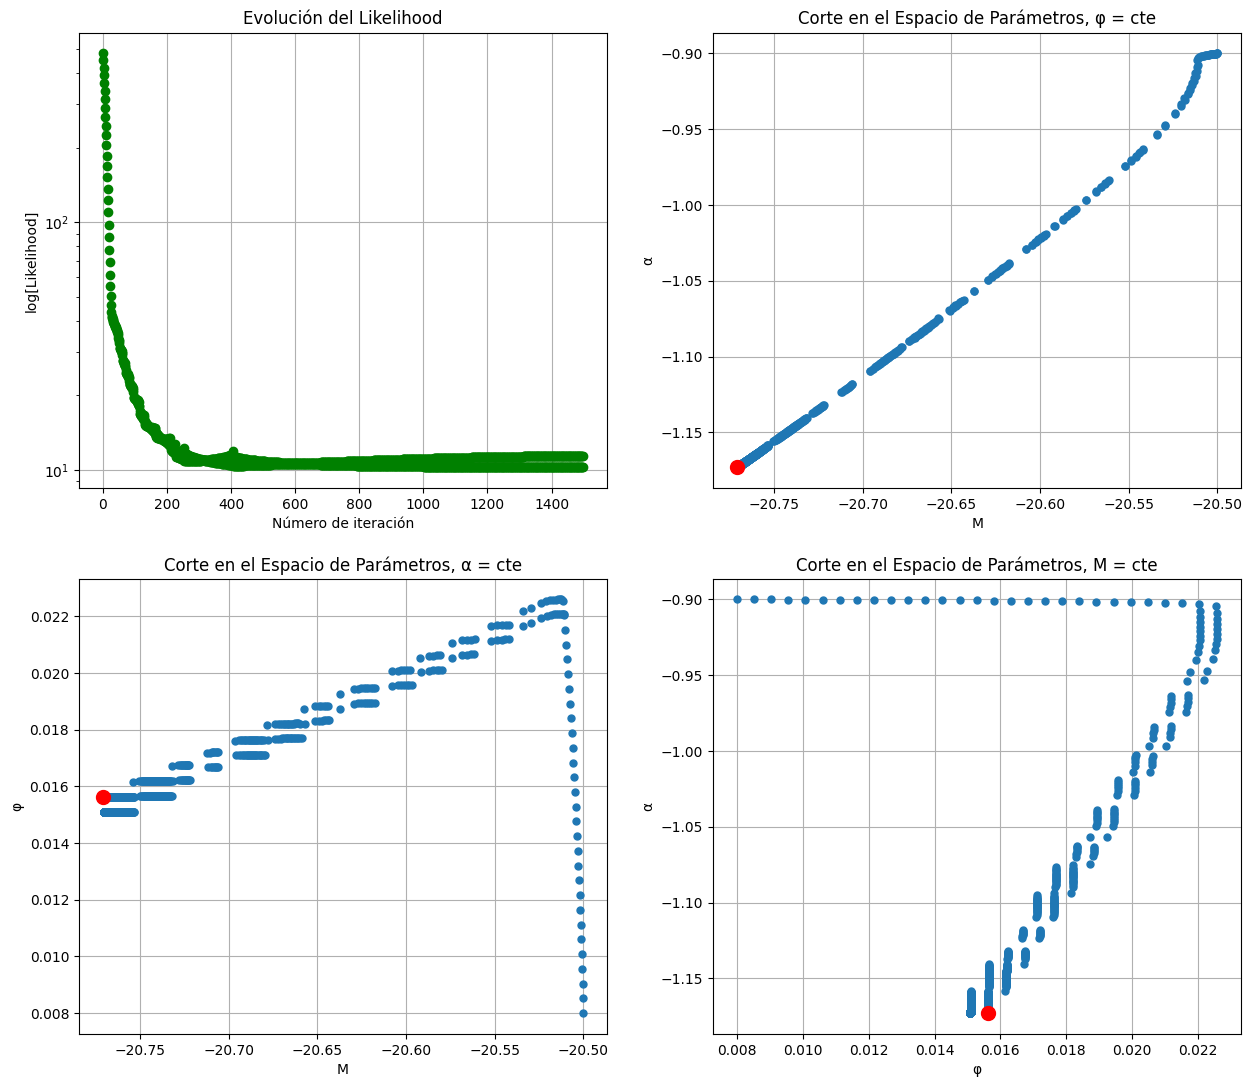

In [44]:
plt.figure(figsize = (15,13))

plt.subplot(2,2,1)
plt.plot(L_grad, '.' , ms = 12 , color = 'g')
plt.xlabel('Número de iteración')
plt.ylabel('log[Likelihood]')
plt.semilogy()
plt.grid()
plt.title('Evolución del Likelihood')

plt.subplot(2,2,2)
plt.plot(parameters[:,0],parameters[:,2],'.',ms = 10)
plt.plot(parameters[N_final-1,0],parameters[N_final-1,2], '.' ,ms = 20,color = 'r')
plt.xlabel('M')
plt.ylabel('α')

plt.grid()
plt.title('Corte en el Espacio de Parámetros, φ = cte')


plt.subplot(2,2,3)
plt.plot(parameters[:,0],parameters[:,1],'.',ms = 10)
plt.plot(parameters[N_final-1,0],parameters[N_final-1,1], '.' ,ms = 20,color = 'r')
plt.xlabel('M')

plt.ylabel('φ')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, α = cte')


plt.subplot(2,2,4)
plt.plot(parameters[:,1],parameters[:,2],'.',ms = 10)
plt.plot(parameters[N_final-1,1],parameters[N_final-1,2], '.' ,ms = 20,color = 'r')
plt.xlabel('φ')
plt.ylabel('α')
#plt.semilogy()
plt.grid()
plt.title('Corte en el Espacio de Parámetros, M = cte')



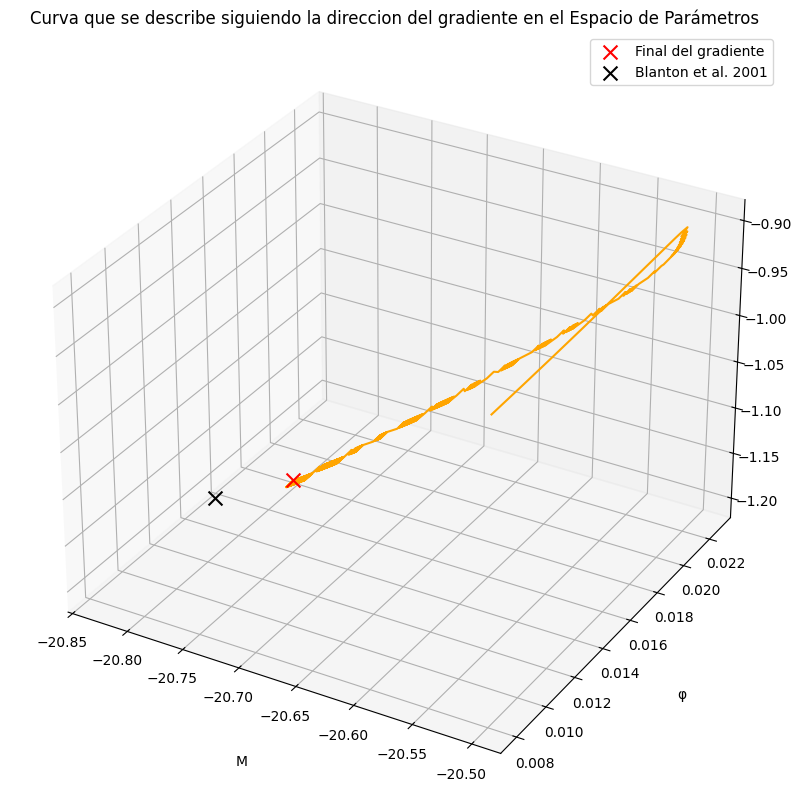

In [47]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection ='3d')
ax.plot3D(  parameters[:,0] ,parameters[:,1], parameters[:,2] , 'orange')
ax.set_title('Curva que se describe siguiendo la direccion del gradiente en el Espacio de Parámetros')
ax.set_xlabel('M', labelpad=20)
ax.set_ylabel('φ', labelpad=20)
ax.set_zlabel('α', labelpad=20)

# Punto final
ax.scatter3D( parameters[N_final-1,0] ,parameters[N_final-1,1], parameters[N_final-1,2] , color='red', s=100, marker='x', label='Final del gradiente')
# Punto Blanton
ax.scatter3D(-20.83, 0.0146, -1.20, color='black', s=100, marker='x', label='Blanton et al. 2001')
ax.legend()

En este caso, a diferencia de lo obtenido en M-H, se puede observar una curva directa que parte de los valores iniciales y se estabiliza alrededor de los parametros que minimizan el (-)likelihood. Otra diferencia clara es que demora mucho menos en converger, con 300 iteraciones ya practicamente se estabilizan los valores de los parametros.

A continuacion, se corren varios caminos de gradiente descendiente, a partir de distintos valores iniciales aleatoriamente escogidos. Luego se calcula el valor medio de los parametros optimos obtenidos con este metodo.

In [ ]:
N_steps = 1500  #numeros maximo de pasos en una cadena
n_paths = 10     # numero de realizaciones (caminos) del metodo del gradiente descendente

I_M = (-21.2 , -20)
I_phi = (0.004 , 0.03)
I_alpha = (-1.4 , -0.9)

eps = 0.001  # no quiero que me elija los extremos del intervalo porque el prior va a dar -inf
M_values = np.linspace(I_M[0] + eps , I_M[1] - eps , 50)   
phi_values = np.linspace(I_phi[0] + eps , I_phi[1] - eps , 50)
alpha_values = np.linspace(I_alpha[0] + eps , I_alpha[1] - eps , 50)

#np.random.seed()
m_init = np.random.choice(M_values , n_paths , replace=False)
#print(m_init)
f_init = np.random.choice(phi_values , n_paths, replace=False )
#print(f_init)
a_init = np.random.choice(alpha_values , n_paths, replace=False)
#print(a_init)

In [52]:
pars = np.zeros((n_paths,N_steps,3))
Likelis = np.zeros((n_paths, N_steps))

for i in range(0,n_paths):
    #print( m_init[i], f_init[i] , a_init[i])
    pars[i,:,:] , Likelis[i,:] = Gradiente_Descendente(N_steps , m_init[i] , f_init[i] , a_init[i])

Text(0.5, 1.0, 'Corte en el Espacio de Parámetros, M = cte')

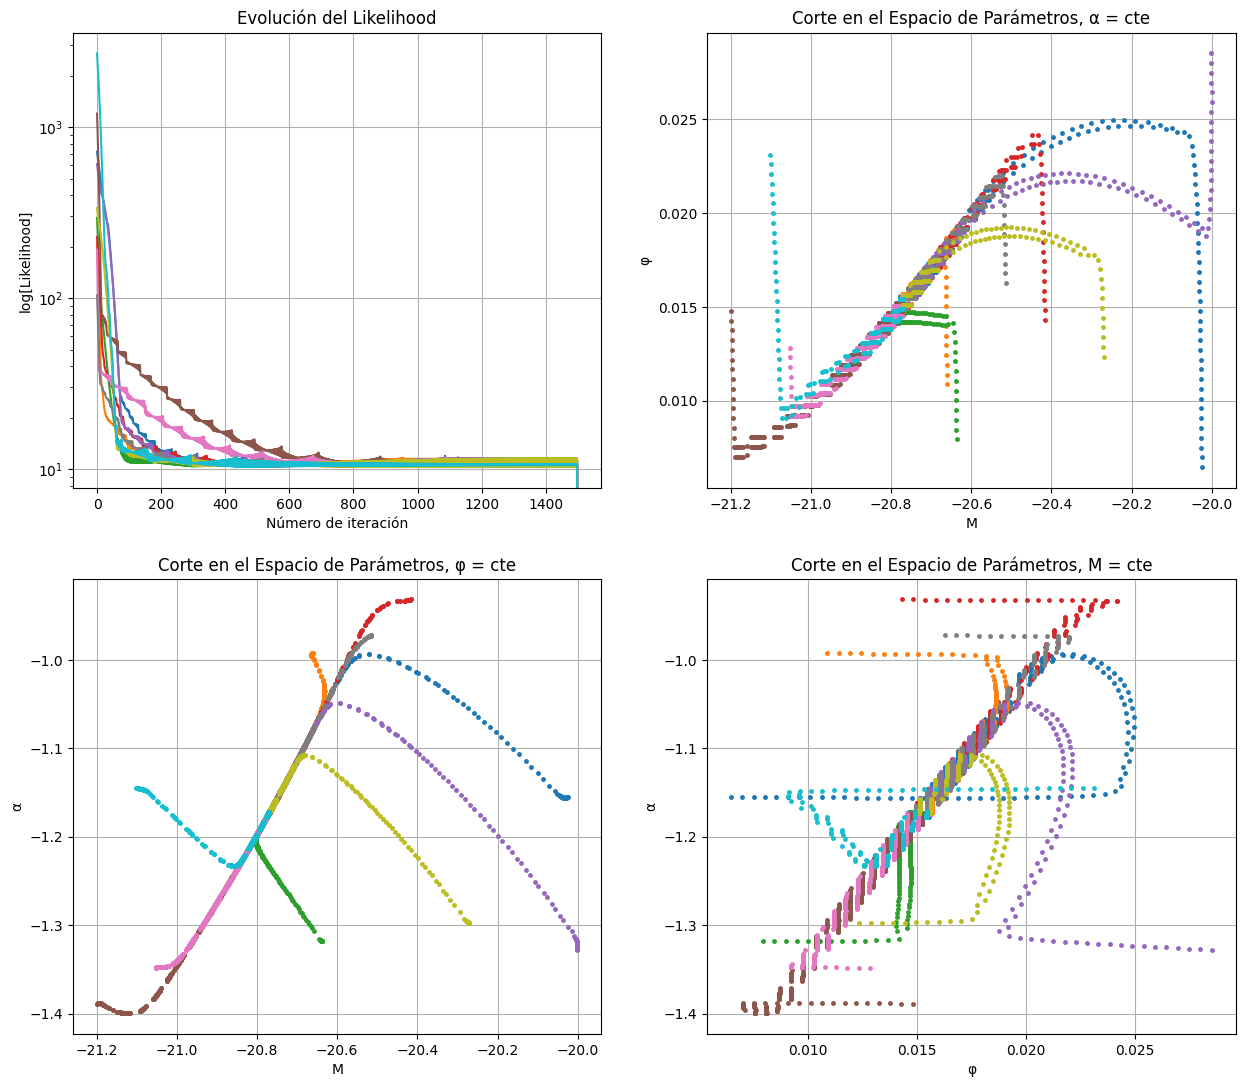

In [53]:
plt.figure(figsize = (15,13))

plt.subplot(2,2,1)
for i in range(0,n_paths):
   plt.plot(Likelis[i,:])

plt.xlabel('Número de iteración')
plt.ylabel('log[Likelihood]')
plt.semilogy()
plt.grid()
plt.title('Evolución del Likelihood')


plt.subplot(2,2,2)
for i in range(n_paths):
  plt.plot(pars[i,:,0],pars[i,:,1],'.',ms = 5)

plt.xlabel('M')
plt.ylabel('φ')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, α = cte')


plt.subplot(2,2,3)
for i in range(n_paths):
  plt.plot(pars[i,:,0],pars[i,:,2],'.',ms = 5)

plt.xlabel('M')
plt.ylabel('α')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, φ = cte')


plt.subplot(2,2,4)
for i in range(n_paths):
  plt.plot(pars[i,:,1],pars[i,:,2],'.',ms = 5)

plt.xlabel('φ')
plt.ylabel('α')
plt.grid()
plt.title('Corte en el Espacio de Parámetros, M = cte')

In [54]:
# quiero obtener la media

# quiero obtener la media
pars.shape
M_list1 = []
phi_list1 = []
alpha_list1 = []

# Obtengo el valor medio de M, phi y alpha para cada cadena de markov (10 medias para cada parametro)
for i in range(n_paths):
    M_list1.append(pars[i,600:,0])
    phi_list1.append(pars[i,600:,1] )
    alpha_list1.append(pars[i,600:,2])

#print(parameters[1000:,2])
#print('todo',parameters[:,2])



# Calculo el M promedio
M_mean_grad = np.mean(M_list1)
M_error_grad = np.std(M_list1)
print(M_mean_grad,M_error_grad )

# Calculo el PHI promedio
phi_mean_grad = np.mean(phi_list1)
phi_error_grad = np.std(phi_list1)
print(phi_mean_grad,phi_error_grad )

# Calculo el ALPHA promedio
alpha_mean_grad = np.mean(alpha_list1)
alpha_error_grad = np.std(alpha_list1)
print(alpha_mean_grad,alpha_error_grad )

-20.771521853357985 0.008170654735681203
0.015124732480523559 0.00037478793183206557
-1.1735881558867105 0.006639277178969139


A partir de realizar un promedio para cada parametro de todos los valores obtenidos en todos los caminos, despues de los 600 primeros pasos, se obtienen los siguientes resultados: 

$$ M_0 = -20.771 \pm 0.008  $$

$$ \phi_0 = (1.51 \pm 0.04) *10^{-2} $$

$$ \alpha_0 = -1.173 \pm 0.007  $$

Se observa que los mismos concuerdan con los encontrados por M-H y al ser este metodo mas eficiente en cuanto a computo para obtenerlos, es el mas conveniente de usar. No obstante, en otro caso donde el likelihood no tenga un solo minimo, lo mas prudente seria usar M-H y explorar adecuadamente el espacio de parametros.

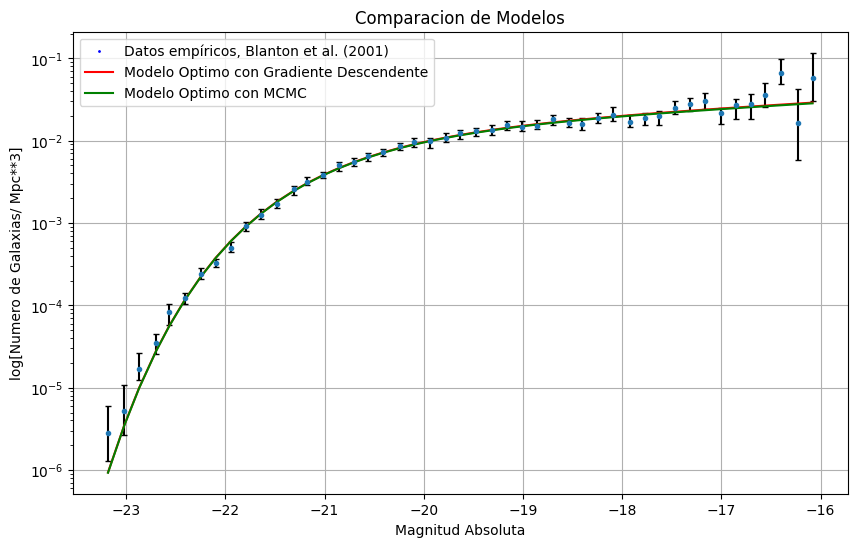

In [ ]:
plt.figure(figsize=(10,6))
#Datos empíricos
plt.plot(M, phi, '.', ms=2, color='b', label="Datos empíricos, Blanton et al. (2001)")
plt.errorbar(M, phi, yerr=phi_err, fmt=".", capsize=2, ecolor="k")

#modelo obtenido con parametros medios que dio el algoritmo de Grad Descen
par_optim_grad = (-20.771, 0.0151, -1.173)
y_optim_grad = phi_modelo(M, par_optim_grad)
plt.plot(M, y_optim_grad, label='Modelo Optimo con Gradiente Descendente', color='r')

#modelo obtenido con parametros medios que dio el algoritmo de Metrop Hast
par_optim_MCMC = (-20.77, 0.015, -1.17)
y__optim_MCMC = phi_modelo(M, par_optim_MCMC)
plt.plot(M, y__optim_MCMC, label='Modelo Optimo con MCMC', color='g')

plt.xlabel('Magnitud Absoluta')
plt.ylabel('log[Numero de Galaxias/ Mpc**3]')
plt.grid()
plt.title('Comparacion de Modelos')
plt.semilogy()
plt.legend()

En este trabajo se han encontrado a traves de dos metodos distintos los valores de los parametros que producen el mejor ajuste a los datos del numero de galaxias por Mpc^3 en funcion de la magnitud, utilizando como modelo la funcion de Schechter. Se observa de la ultima figura que los valores que predice para los parametros el metodo de Metropolis-Hastings concuerdan con el de Gradiente Descendente, y a su vez concuerdan dentro del margen de error con los obtenidos por Blanton et al. (2001).

Metropolis-Hastings :
$$ M_0 = -20.77 \pm 0.04  $$

$$ \phi_0 = (1.5 \pm 0.1) *10^{-2} $$

$$ \alpha_0 = -1.17 \pm 0.03  $$


Gradiente Descendente:
$$ M_0 = -20.771 \pm 0.008  $$

$$ \phi_0 = (1.51 \pm 0.04) *10^{-2} $$

$$ \alpha_0 = -1.173 \pm 0.007  $$

Blanton:
$$ M_0 = -20.83 \pm 0.03  $$

$$ \phi_0 = (1.46 \pm 0.12) *10^{-2} $$

$$ \alpha_0 = -1.20 \pm 0.03  $$

Por ultimo, se destaca que el metodo del gradiente es el mas eficiente de usar en este caso ya que converge rapidamente  y la funcion del likelihood tiene un solo minimo. No obstante, puede que este metodo parezca tener una presicion mayor que no es tal, ya que el error tan chico que se obtiene es mas bien producto del hecho que no se exploro el espacio de parametros en profundidad. Por lo tanto, el metodo de Metropolis-Hastings, si bien es mas costoso computacionalmente , es el mas prudente de utilizar para explorar adecuadamente los posibles valores de los parametros que pueden ajustar el modelo a los datos; siempre y cuando se tenga el cuidado tambien de que se produzca un buen mezclado de las cadenas. 